Happy Customer Bank is a mid-sized private bank that deals in all kinds of banking products, like Savings accounts, Current accounts, investment products, credit products, among other offerings.

The bank also cross-sells products to its existing customers and to do so they use different kinds of communication like tele-calling, e-mails, recommendations on net banking, mobile banking, etc. 

In this case, the Happy Customer Bank wants to cross sell its credit cards to its existing customers. The bank has identified a set of customers that are eligible for taking these credit cards.

Now, the bank is looking for your help in identifying customers that could show higher intent towards a recommended credit card, given:

Customer details (gender, age, region etc.)
Details of his/her relationship with the bank (Channel_Code,Vintage, 'Avg_Asset_Value etc.)


Data Dictionary
-----------------------

*ID : Unique Identifier for a row

*Gender : Gender of the Customer

*Age : Age of the Customer (in Years)

*Region_Code : Code of the Region for the customers

*Occupation : Occupation Type for the customer

*Channel_Code : Acquisition Channel Code for the Customer  (Encoded)

*Vintage : Vintage for the Customer (In Months)

*Credit_Product : If the Customer has any active credit product (Home loan, Personal loan, Credit Card etc.)

*Avg_Account_Balance : Average Account Balance for the Customer in last 12 Months

*Is_Active : If the Customer is Active in last 3 Months

*Is_Lead(Target) : If the Customer is interested for the Credit Card

                                    0 : Customer is not interested

                                    1 : Customer is interested

### Importing Libraries

In [1]:
# Importing required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

### Data Inspection

In [2]:
train = pd.read_csv('train_s3TEQDk.csv')
test = pd.read_csv('test_mSzZ8RL.csv')

In [3]:
train.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,NNVBBKZB,Female,73,RG268,Other,X3,43,No,1045696,No,0
1,IDD62UNG,Female,30,RG277,Salaried,X1,32,No,581988,No,0
2,HD3DSEMC,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,0
3,BF3NC7KV,Male,34,RG270,Salaried,X1,19,No,470454,No,0
4,TEASRWXV,Female,30,RG282,Salaried,X1,33,No,886787,No,0


In [4]:
test.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active
0,VBENBARO,Male,29,RG254,Other,X1,25,Yes,742366,No
1,CCMEWNKY,Male,43,RG268,Other,X2,49,NaN,925537,No
2,VK3KGA9M,Male,31,RG270,Salaried,X1,14,No,215949,No
3,TT8RPZVC,Male,29,RG272,Other,X1,33,No,868070,No
4,SHQZEYTZ,Female,29,RG270,Other,X1,19,No,657087,No


In [5]:
train.shape, test.shape

((245725, 11), (105312, 10))

* We have 245725 rows with 11 columns of data in Train set 
* We have 105312 rows with 10 columns of data in Test set


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245725 entries, 0 to 245724
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ID                   245725 non-null  object
 1   Gender               245725 non-null  object
 2   Age                  245725 non-null  int64 
 3   Region_Code          245725 non-null  object
 4   Occupation           245725 non-null  object
 5   Channel_Code         245725 non-null  object
 6   Vintage              245725 non-null  int64 
 7   Credit_Product       216400 non-null  object
 8   Avg_Account_Balance  245725 non-null  int64 
 9   Is_Active            245725 non-null  object
 10  Is_Lead              245725 non-null  int64 
dtypes: int64(4), object(7)
memory usage: 20.6+ MB


* Numerical Features: 3
* Categorical Features: 8 
  
  (Though Is_Lead has dtype of int64, we consider it as categorical feature as a binary) 

In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105312 entries, 0 to 105311
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ID                   105312 non-null  object
 1   Gender               105312 non-null  object
 2   Age                  105312 non-null  int64 
 3   Region_Code          105312 non-null  object
 4   Occupation           105312 non-null  object
 5   Channel_Code         105312 non-null  object
 6   Vintage              105312 non-null  int64 
 7   Credit_Product       92790 non-null   object
 8   Avg_Account_Balance  105312 non-null  int64 
 9   Is_Active            105312 non-null  object
dtypes: int64(3), object(7)
memory usage: 8.0+ MB


* Numerical Features: 3
* Categorical Features: 7 
  

### Data Cleaning

##### Handling Missing values
Missing values may be due to multiple reasons like unrecorded observations or data corruption. 

Handling missing data is important as many machine learning algorithms do not support data with missing values.

In [8]:
# null values in train data
train.isnull().sum()

ID                         0
Gender                     0
Age                        0
Region_Code                0
Occupation                 0
Channel_Code               0
Vintage                    0
Credit_Product         29325
Avg_Account_Balance        0
Is_Active                  0
Is_Lead                    0
dtype: int64

In [9]:
# null values in test data
test.isnull().sum()

ID                         0
Gender                     0
Age                        0
Region_Code                0
Occupation                 0
Channel_Code               0
Vintage                    0
Credit_Product         12522
Avg_Account_Balance        0
Is_Active                  0
dtype: int64

###### We found that there were missing values in Credit_Product in both train and test data

In [10]:
print(train['Credit_Product'].value_counts())

print('\n\n',test['Credit_Product'].value_counts())

No     144357
Yes     72043
Name: Credit_Product, dtype: int64


 No     61608
Yes    31182
Name: Credit_Product, dtype: int64


###### Since Credict_Product is categorical, we replace the missing values with Most frequent value (Mode)

In [11]:
# # Filling missing values in train and test data using fillna()
# train['Credit_Product'] = train['Credit_Product'].fillna(train['Credit_Product'].mode()[0])

# test['Credit_Product'] = test['Credit_Product'].fillna(test['Credit_Product'].mode()[0])

In [12]:
# Instead tried this method also to fill the null values

train['Credit_Product'] = train['Credit_Product'].fillna(method = 'ffill',axis=0)
test['Credit_Product'] = test['Credit_Product'].fillna(method = 'ffill',axis=0)

In [13]:
train['Credit_Product'].isnull().sum(), test['Credit_Product'].isnull().sum()

(0, 0)

### Exploratory Data Analysis

In [14]:
train.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,NNVBBKZB,Female,73,RG268,Other,X3,43,No,1045696,No,0
1,IDD62UNG,Female,30,RG277,Salaried,X1,32,No,581988,No,0
2,HD3DSEMC,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,0
3,BF3NC7KV,Male,34,RG270,Salaried,X1,19,No,470454,No,0
4,TEASRWXV,Female,30,RG282,Salaried,X1,33,No,886787,No,0


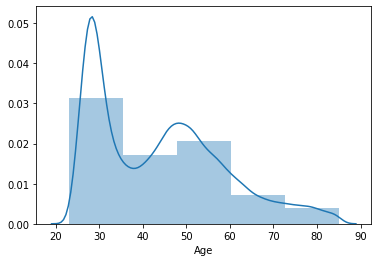

In [15]:
sns.distplot(train['Age'], bins=5)
plt.show()

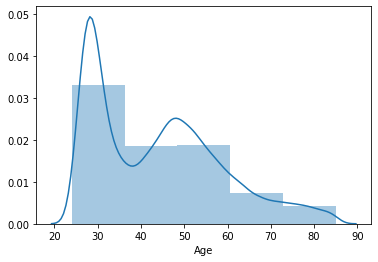

In [16]:
sns.distplot(test['Age'], bins=5)
plt.show()

###### We observe the customers that are eligible for taking the recommended credit cards were mostly in the age range of 20 to 35 yrs in both train and test data

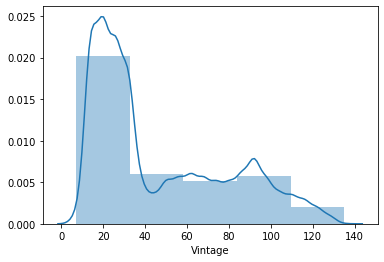

In [17]:
sns.distplot(train['Vintage'], bins=5)
plt.show()

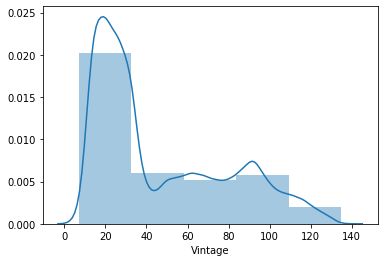

In [18]:
sns.distplot(test['Vintage'], bins=5)
plt.show()

###### We observe that majority of customers selected as eligible for taking the recommended credit card has Vintage b/w 0-30 months in both train and test data

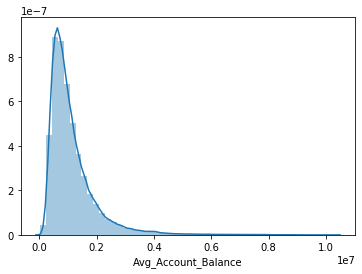

In [19]:
sns.distplot(train['Avg_Account_Balance'])
plt.show()

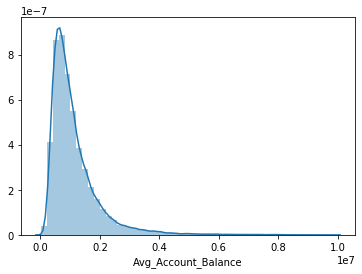

In [20]:
sns.distplot(test['Avg_Account_Balance'])
plt.show()

###### Here we observe that, customers have most of the Avg account balance b/w 0-200000 and it is positively skewed in both train and test data

###### We try to normalise them using numpy log() function

In [21]:
train['Avg_Account_Balance'] = np.log(train['Avg_Account_Balance'])
test['Avg_Account_Balance'] = np.log(test['Avg_Account_Balance'])

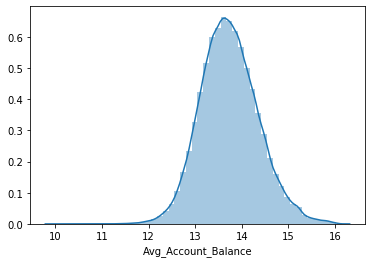

In [22]:
sns.distplot(train['Avg_Account_Balance'])
plt.show()

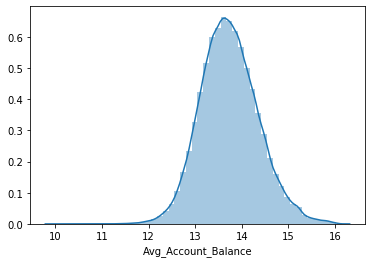

In [23]:
sns.distplot(train['Avg_Account_Balance'])
plt.show()

###### Thus we normalised Avg_Account_Balance

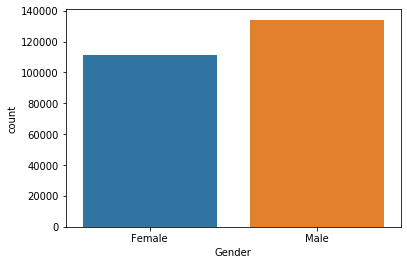

In [24]:
sns.countplot('Gender', data = train)

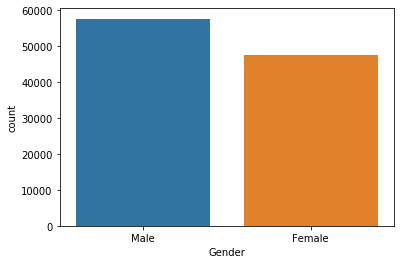

In [25]:
sns.countplot('Gender', data = test)

###### Here we can observe that among the customers selected by the Happy Customer Bank, Male customers are more compared to Female customers in both train and test data

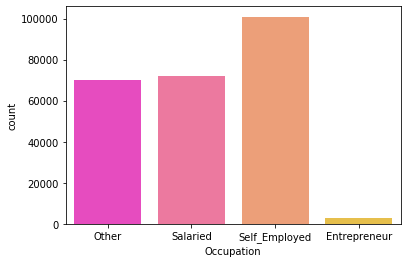

In [26]:
sns.countplot('Occupation', data = train, palette='spring')

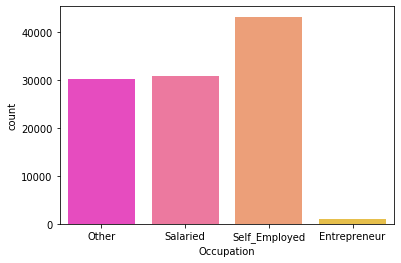

In [27]:
sns.countplot('Occupation', data = test, palette='spring')

###### Here we can observe that Self_employed customers are more and Entrepreneur customers are least in count in both train and test data

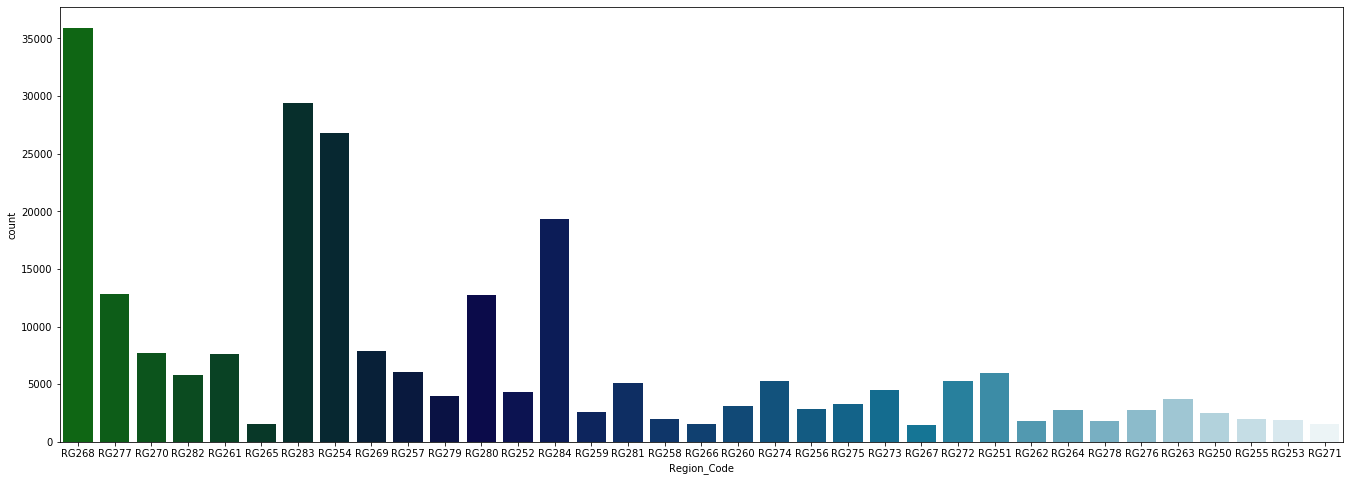

In [28]:
plt.figure(figsize=(23,8))
sns.countplot('Region_Code', data = train, palette='ocean')

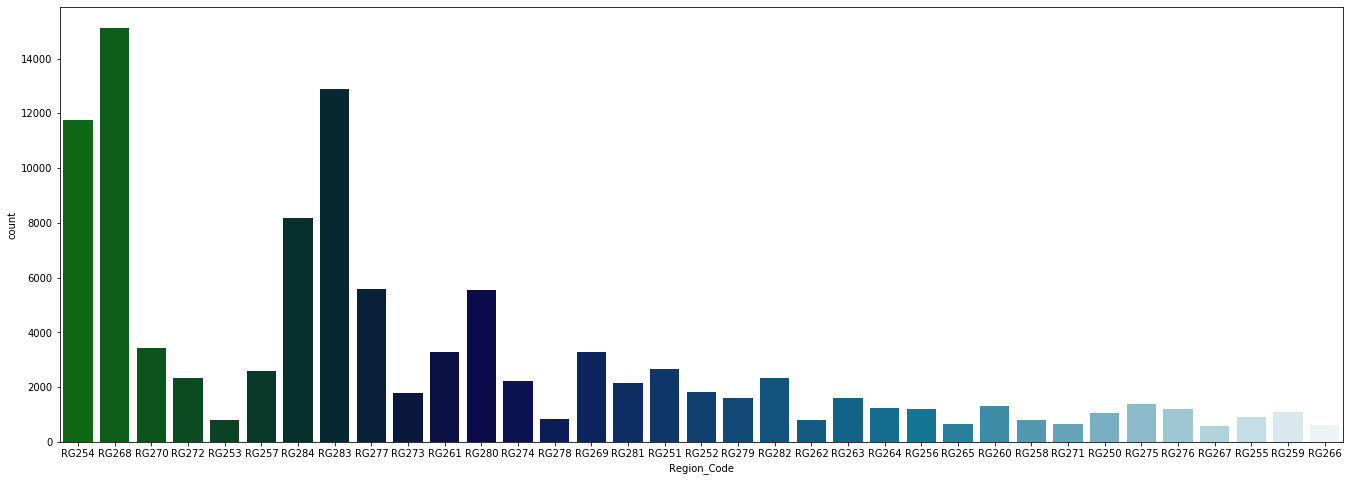

In [29]:
plt.figure(figsize=(23,8))
sns.countplot('Region_Code', data = test, palette='ocean')

###### Customers selected by the bank are mostly from region with code of RG268 in both train and test data

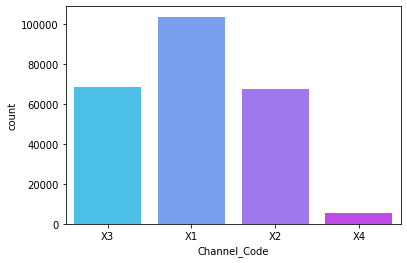

In [30]:
sns.countplot('Channel_Code', data = train, palette='cool')

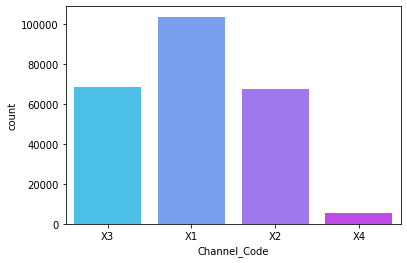

In [31]:
sns.countplot('Channel_Code', data = train, palette='cool')

###### Acquisition Channel_code of X1 is more in count and X4 is in least in both train and test data

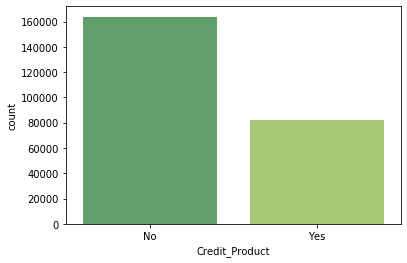

In [32]:
sns.countplot('Credit_Product', data = train, palette='summer')

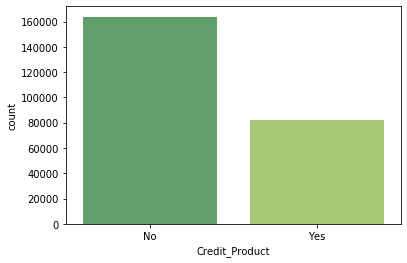

In [33]:
sns.countplot('Credit_Product', data = train, palette='summer')

###### We Observe that majority of Customer has NO active credit product in both train nad test data

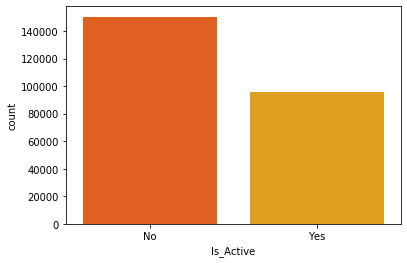

In [34]:
sns.countplot('Is_Active', data = train, palette='autumn')

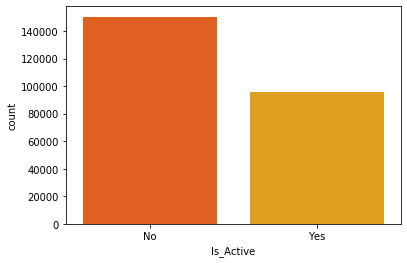

In [35]:
sns.countplot('Is_Active', data = train, palette='autumn')

###### Majority of Customers are InActive in last 3 Months in both train and test data

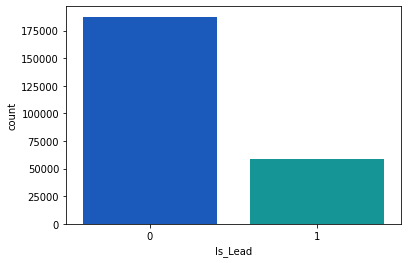

In [36]:
sns.countplot('Is_Lead', data = train, palette='winter')

###### We can observe class-0 dominance in target variable Is_Lead

In [37]:
train.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,NNVBBKZB,Female,73,RG268,Other,X3,43,No,13.860193,No,0
1,IDD62UNG,Female,30,RG277,Salaried,X1,32,No,13.274205,No,0
2,HD3DSEMC,Female,56,RG268,Self_Employed,X3,26,No,14.210464,Yes,0
3,BF3NC7KV,Male,34,RG270,Salaried,X1,19,No,13.061453,No,0
4,TEASRWXV,Female,30,RG282,Salaried,X1,33,No,13.695360,No,0


In [38]:
# Dropping 'ID' column

train.drop('ID',axis=1,inplace=True)
test.drop('ID',axis=1, inplace=True)

### Encoding Categorical Data

In [39]:
# Converting Region_code to numerical by removing 'RG'

# train
rg_tr = []
for i in train['Region_Code']:
    i = i.replace('RG','')
    rg_tr.append(int(i))
train['Region_Code'] = rg_tr

# test
rg_ts = []
for i in test['Region_Code']:
    i = i.replace('RG','')
    rg_ts.append(int(i))
test['Region_Code'] = rg_ts

In [40]:
train['Region_Code'].head()

0    268
1    277
2    268
3    270
4    282
Name: Region_Code, dtype: int64

In [41]:
# Converting Channel_code to numerical by removing 'X'

# train
ch_tr = []
for i in train['Channel_Code']:
    i = i.replace('X','')
    ch_tr.append(int(i))
train['Channel_Code'] = ch_tr

# test
ch_ts = []
for i in test['Channel_Code']:
    i = i.replace('X','')
    ch_ts.append(int(i))
test['Channel_Code'] = ch_ts

In [42]:
train['Channel_Code'].head()

0    3
1    1
2    3
3    1
4    1
Name: Channel_Code, dtype: int64

In [43]:
# Encoding other categorical variables with One Hot Encoding
Train = pd.get_dummies(train, columns=['Gender','Occupation','Credit_Product','Is_Active'], drop_first=True)

In [44]:
Train.head()

,Age,Region_Code,Channel_Code,Vintage,Avg_Account_Balance,Is_Lead,Gender_Male,Occupation_Other,Occupation_Salaried,Occupation_Self_Employed,Credit_Product_Yes,Is_Active_Yes
0,73,268,3,43,13.860193,0,0,1,0,0,0,0
1,30,277,1,32,13.274205,0,0,0,1,0,0,0
2,56,268,3,26,14.210464,0,0,0,0,1,0,1
3,34,270,1,19,13.061453,0,1,0,1,0,0,0
4,30,282,1,33,13.695360,0,0,0,1,0,0,0


In [45]:
# Encoding other categorical variables with One Hot Encoding
Test = pd.get_dummies(test, columns=['Gender','Occupation','Credit_Product','Is_Active'], drop_first=True)

In [46]:
Test.head()

,Age,Region_Code,Channel_Code,Vintage,Avg_Account_Balance,Gender_Male,Occupation_Other,Occupation_Salaried,Occupation_Self_Employed,Credit_Product_Yes,Is_Active_Yes
0,29,254,1,25,13.517598,1,1,0,0,1,0
1,43,268,2,49,13.738129,1,1,0,0,1,0
2,31,270,1,14,12.282798,1,0,1,0,0,0
3,29,272,1,33,13.674028,1,1,0,0,0,0
4,29,270,1,19,13.395572,0,1,0,0,0,0


### Building Model

In [47]:
# Spit data to dependent and independent variables
x = Train.drop(columns = ['Is_Lead'], axis=1)
y = Train['Is_Lead']

In [48]:
# Split data to train and validation
x_train, x_test, y_train, y_test  = train_test_split(x,y, test_size=0.2, random_state=21)

In [49]:
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

In [50]:
# Trying other ML algorithms
algs = [LogisticRegression(), RandomForestClassifier(), AdaBoostClassifier(), GradientBoostingClassifier(), XGBClassifier()]

models = ['Logistic Regression', 'Random Forest Classifier', 'AdaBoost Classifier', 'GradientBoostng Classifier', 'XGBoost Classifier']

roc_all = []

for i in algs:
    model = i
    model.fit(x_train,y_train)
    y_pred = model.predict_proba(x_test)[:,1]
    roc = roc_auc_score(y_test, y_pred)
    roc_all.append(roc)

In [51]:
# Evaluation
evaluation = pd.DataFrame({'Model': models, 'ROC': roc_all})

In [52]:
evaluation

,Model,ROC
0,Logistic Regression,0.742105
1,Random Forest Classifier,0.767345
2,AdaBoost Classifier,0.772242
3,GradientBoostng Classifier,0.790835
4,XGBoost Classifier,0.794505


###### Here we can observe that XG Boost Classifier has got better roc_auc_score compared to other classifiers

###### Since our data has got Label imbalance(0 category is dominating 1 category), this may be one of the reason for less roc_auc_score. So, we balance our label by upsampling the class 1.

In [53]:
# UpSampling the class 1

count_0,count_1 = Train['Is_Lead'].value_counts()

class_1 = Train[Train['Is_Lead']==1]
class_0 = Train[Train['Is_Lead']==0]

over_1 = class_1.sample(count_0,random_state=42,replace=True)
new_train = pd.concat([over_1,class_0],axis=0)
new_train['Is_Lead'].value_counts()

1    187437
0    187437
Name: Is_Lead, dtype: int64

###### Now we repeat the process that we followed building the model to the resultant Upsampled data

### Building Model

In [54]:
# Spit data to dependent and independent variables
X = new_train.drop(columns = ['Is_Lead'], axis=1)
Y = new_train['Is_Lead']

In [55]:
# Split data to train and validation
X_train, X_test, Y_train, Y_test  = train_test_split(X,Y, test_size=0.2, random_state=21)

In [56]:
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [57]:
# Trying other ML algorithms
algs = [LogisticRegression(), RandomForestClassifier(), AdaBoostClassifier(), GradientBoostingClassifier(), XGBClassifier()]

models = ['Logistic Regression', 'Random Forest Classifier', 'AdaBoost Classifier', 'GradientBoostng Classifier', 'XGBoost Classifier']

new_roc_all = []

for i in algs:
    model = i
    model.fit(X_train,Y_train)
    Y_pred = model.predict_proba(X_test)[:,1]
    roc = roc_auc_score(Y_test, Y_pred)
    new_roc_all.append(roc)

In [58]:
# Evaluation
new_evaluation = pd.DataFrame({'Model': models, 'ROC': new_roc_all})

In [59]:
new_evaluation

,Model,ROC
0,Logistic Regression,0.748667
1,Random Forest Classifier,0.976865
2,AdaBoost Classifier,0.779343
3,GradientBoostng Classifier,0.798962
4,XGBoost Classifier,0.817182


###### We can now observe drastic improvement in roc_auc_score of Random Forest Classifier which is better compared to other models after balancing labels of the data

In [60]:
# submission = pd.read_csv('sample_submission_eyYijxG.csv')
# model = RandomForestClassifier()
# model.fit(X, Y)
# final_predictions = model.predict(Test)
# submission['Is_Lead'] = final_predictions
# #only positive predictions for the target variable
# submission.to_csv('my_submission.csv', index=False)

###### Now we will try improving score for Random Forest Classifier by Hyper parameter Tuning

In [61]:
# Model Building

rf = RandomForestClassifier(
                      n_estimators=150,
                      bootstrap=True,
                      oob_score=True,
                      n_jobs=-1,
                      random_state=32,
                      max_features='auto')
rf.fit(X_train,Y_train)
Y_pred = rf.predict_proba(X_test)[:,1]
rf_roc = roc_auc_score(Y_test,Y_pred)
rf_roc

0.9772348950299161

In [62]:
# submission = pd.read_csv('sample_submission_eyYijxG.csv')
# final_predictions = rf.predict(Test)
# submission['Is_Lead'] = final_predictions
# #only positive predictions for the target variable
# submission.to_csv('my_submission1.csv', index=False)

###### Since we observe overfitting after submission, we try using other algorithms

###### Lets try with XG Boost

In [ ]:
# Model Building

xgb = XGBClassifier(
                      n_estimators= 2000, 
             max_depth= 10, 
             learning_rate= 0.001)
xgb.fit(X_train,Y_train)
Y_pred = xgb.predict_proba(X_test)[:,1]
xgb_roc = roc_auc_score(Y_test,Y_pred)
xgb_roc

In [ ]:
# submission = pd.read_csv('sample_submission_eyYijxG.csv')
# submission['Is_Lead'] = xgb.predict_proba(Test)[:,1]
# submission.to_csv('my_submission9.csv', index=False)

### LightGBM

In [ ]:
from lightgbm import LGBMClassifier

In [ ]:
params = {'n_estimators': 10000, 'n_jobs': -1, 'random_state': 21, 'learning_rate': 0.1, 'colsample_bytree': 0.5}
lgb = LGBMClassifier(**params)

In [ ]:
lgb.fit(X_train, Y_train, eval_set =[(X_test, Y_test)],  early_stopping_rounds=200, verbose=1000, eval_metric='auc')

In [ ]:
Y_pred = lgb.predict_proba(X_test)[:,1]
lgb_roc = roc_auc_score(Y_test,Y_pred)
lgb_roc

In [ ]:
roc = (rf_roc + xgb_roc + lgb_roc)/3

In [57]:
# submission = pd.read_csv('sample_submission_eyYijxG.csv')
# final_predictions = lgb.predict_proba(Test)[:,1]
# submission['Is_Lead'] = final_predictions
# submission.to_csv('my_submission9.csv', index=False)

###### Even in this case we observe overfitting so, trying with CatBoost Classifier

For Cat Boost Classifier, we need not encode the categorical data. It does by its own. 

So we use data of train and test before encoding the categorial features

### CatBoost Classifier

In [58]:
# Spit data to dependent and independent variables
x = train.drop(columns = ['Is_Lead'], axis=1)
y = train['Is_Lead']

In [59]:
# Split data to train and validation
x_train, x_test, y_train, y_test  = train_test_split(x,y, test_size=0.2, random_state=21)

In [60]:
cat_feat = ['Gender', 'Region_Code','Occupation','Channel_Code','Credit_Product','Is_Active']

In [61]:
cat = CatBoostClassifier(iterations=400,learning_rate=0.2,depth=3,random_seed=42)

In [62]:
cat.fit(x_train,y_train,eval_set=(x_test,y_test),cat_features=cat_feat,plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6055759	test: 0.6062346	best: 0.6062346 (0)	total: 402ms	remaining: 2m 40s
1:	learn: 0.5483257	test: 0.5498509	best: 0.5498509 (1)	total: 578ms	remaining: 1m 54s
2:	learn: 0.5109963	test: 0.5130584	best: 0.5130584 (2)	total: 751ms	remaining: 1m 39s
3:	learn: 0.4917017	test: 0.4942389	best: 0.4942389 (3)	total: 897ms	remaining: 1m 28s
4:	learn: 0.4742817	test: 0.4770892	best: 0.4770892 (4)	total: 1.05s	remaining: 1m 22s
5:	learn: 0.4657270	test: 0.4687762	best: 0.4687762 (5)	total: 1.17s	remaining: 1m 17s
6:	learn: 0.4591371	test: 0.4623495	best: 0.4623495 (6)	total: 1.29s	remaining: 1m 12s
7:	learn: 0.4546828	test: 0.4579946	best: 0.4579946 (7)	total: 1.41s	remaining: 1m 9s
8:	learn: 0.4524722	test: 0.4558925	best: 0.4558925 (8)	total: 1.54s	remaining: 1m 7s
9:	learn: 0.4501181	test: 0.4537641	best: 0.4537641 (9)	total: 1.67s	remaining: 1m 5s
10:	learn: 0.4478869	test: 0.4516106	best: 0.4516106 (10)	total: 1.79s	remaining: 1m 3s
11:	learn: 0.4463030	test: 0.4501786	best: 0.

94:	learn: 0.4314191	test: 0.4368318	best: 0.4368318 (94)	total: 11.9s	remaining: 38.4s
95:	learn: 0.4313925	test: 0.4368169	best: 0.4368169 (95)	total: 12.1s	remaining: 38.2s
96:	learn: 0.4313102	test: 0.4367632	best: 0.4367632 (96)	total: 12.2s	remaining: 38.1s
97:	learn: 0.4312681	test: 0.4367358	best: 0.4367358 (97)	total: 12.3s	remaining: 37.9s
98:	learn: 0.4312418	test: 0.4367092	best: 0.4367092 (98)	total: 12.4s	remaining: 37.7s
99:	learn: 0.4312124	test: 0.4366813	best: 0.4366813 (99)	total: 12.5s	remaining: 37.5s
100:	learn: 0.4311651	test: 0.4366461	best: 0.4366461 (100)	total: 12.6s	remaining: 37.4s
101:	learn: 0.4311379	test: 0.4366303	best: 0.4366303 (101)	total: 12.7s	remaining: 37.2s
102:	learn: 0.4311174	test: 0.4366270	best: 0.4366270 (102)	total: 12.9s	remaining: 37.1s
103:	learn: 0.4310759	test: 0.4365769	best: 0.4365769 (103)	total: 13s	remaining: 36.9s
104:	learn: 0.4310670	test: 0.4365698	best: 0.4365698 (104)	total: 13.1s	remaining: 36.7s
105:	learn: 0.4310557	te

186:	learn: 0.4293749	test: 0.4357296	best: 0.4357294 (184)	total: 23.1s	remaining: 26.3s
187:	learn: 0.4293680	test: 0.4357304	best: 0.4357294 (184)	total: 23.2s	remaining: 26.2s
188:	learn: 0.4293680	test: 0.4357304	best: 0.4357294 (184)	total: 23.3s	remaining: 26.1s
189:	learn: 0.4293548	test: 0.4357174	best: 0.4357174 (189)	total: 23.5s	remaining: 25.9s
190:	learn: 0.4293402	test: 0.4357313	best: 0.4357174 (189)	total: 23.6s	remaining: 25.8s
191:	learn: 0.4293301	test: 0.4357348	best: 0.4357174 (189)	total: 23.7s	remaining: 25.7s
192:	learn: 0.4293144	test: 0.4357359	best: 0.4357174 (189)	total: 23.9s	remaining: 25.6s
193:	learn: 0.4293124	test: 0.4357357	best: 0.4357174 (189)	total: 24s	remaining: 25.5s
194:	learn: 0.4292848	test: 0.4357328	best: 0.4357174 (189)	total: 24.1s	remaining: 25.4s
195:	learn: 0.4292542	test: 0.4357012	best: 0.4357012 (195)	total: 24.2s	remaining: 25.2s
196:	learn: 0.4292505	test: 0.4357006	best: 0.4357006 (196)	total: 24.4s	remaining: 25.1s
197:	learn: 

278:	learn: 0.4282263	test: 0.4351975	best: 0.4351975 (278)	total: 35.4s	remaining: 15.3s
279:	learn: 0.4282195	test: 0.4351929	best: 0.4351929 (279)	total: 35.5s	remaining: 15.2s
280:	learn: 0.4282153	test: 0.4351885	best: 0.4351885 (280)	total: 35.6s	remaining: 15.1s
281:	learn: 0.4282122	test: 0.4351878	best: 0.4351878 (281)	total: 35.7s	remaining: 15s
282:	learn: 0.4281969	test: 0.4351839	best: 0.4351839 (282)	total: 35.9s	remaining: 14.8s
283:	learn: 0.4281793	test: 0.4351673	best: 0.4351673 (283)	total: 36s	remaining: 14.7s
284:	learn: 0.4281767	test: 0.4351668	best: 0.4351668 (284)	total: 36.1s	remaining: 14.6s
285:	learn: 0.4281722	test: 0.4351636	best: 0.4351636 (285)	total: 36.3s	remaining: 14.5s
286:	learn: 0.4281605	test: 0.4351563	best: 0.4351563 (286)	total: 36.4s	remaining: 14.3s
287:	learn: 0.4281530	test: 0.4351494	best: 0.4351494 (287)	total: 36.5s	remaining: 14.2s
288:	learn: 0.4281384	test: 0.4351481	best: 0.4351481 (288)	total: 36.6s	remaining: 14.1s
289:	learn: 0.

371:	learn: 0.4273387	test: 0.4349211	best: 0.4349211 (371)	total: 48.1s	remaining: 3.62s
372:	learn: 0.4273372	test: 0.4349217	best: 0.4349211 (371)	total: 48.2s	remaining: 3.49s
373:	learn: 0.4273305	test: 0.4349276	best: 0.4349211 (371)	total: 48.3s	remaining: 3.36s
374:	learn: 0.4273273	test: 0.4349259	best: 0.4349211 (371)	total: 48.5s	remaining: 3.23s
375:	learn: 0.4273204	test: 0.4349217	best: 0.4349211 (371)	total: 48.7s	remaining: 3.1s
376:	learn: 0.4273186	test: 0.4349217	best: 0.4349211 (371)	total: 48.8s	remaining: 2.97s
377:	learn: 0.4273040	test: 0.4349267	best: 0.4349211 (371)	total: 48.9s	remaining: 2.85s
378:	learn: 0.4272966	test: 0.4349155	best: 0.4349155 (378)	total: 49.1s	remaining: 2.72s
379:	learn: 0.4272957	test: 0.4349150	best: 0.4349150 (379)	total: 49.2s	remaining: 2.59s
380:	learn: 0.4272921	test: 0.4349118	best: 0.4349118 (380)	total: 49.4s	remaining: 2.46s
381:	learn: 0.4272890	test: 0.4349108	best: 0.4349108 (381)	total: 49.6s	remaining: 2.33s
382:	learn:

In [63]:
y_pred = cat.predict_proba(x_test)[:,1]
cat_roc = roc_auc_score(y_test,y_pred)
cat_roc

0.7949655843610897

###### Trying to check roc_auc_score after upsampling the data

In [233]:
# UpSampling the class 1

count_0,count_1 = train['Is_Lead'].value_counts()

class_1 = train[train['Is_Lead']==1]
class_0 = train[train['Is_Lead']==0]

over_1 = class_1.sample(count_0,random_state=42,replace=True)
new_train = pd.concat([over_1,class_0],axis=0)
new_train['Is_Lead'].value_counts()

1    187437
0    187437
Name: Is_Lead, dtype: int64

In [234]:
# new_train.drop(['Region_Code'],axis=1,inplace=True)
# test.drop(['Region_Code'],axis=1,inplace=True)

In [235]:
# new_train.drop(['Gender'],axis=1,inplace=True)
# test.drop(['Gender'],axis=1,inplace=True)

###### Tried by dropping some columns, assuming that they are not much required. But assumption was wrong. So continued with full dataset

In [236]:
# Spit data to dependent and independent variables
x = new_train.drop(columns = ['Is_Lead'], axis=1)
y = new_train['Is_Lead']

In [237]:
# Split data to train and validation
x_train, x_test, y_train, y_test  = train_test_split(x,y, test_size=0.2, random_state=29)

In [238]:
cat_feat = ['Gender','Region_Code','Occupation','Channel_Code','Credit_Product','Is_Active']

In [239]:
cat = CatBoostClassifier(iterations=800,learning_rate=0.01,max_depth=10,random_state=29,l2_leaf_reg=10)

In [240]:
cat.fit(x_train,y_train,eval_set=(x_test,y_test),cat_features=cat_feat)

0:	learn: 0.6896426	test: 0.6896495	best: 0.6896495 (0)	total: 377ms	remaining: 5m
1:	learn: 0.6863968	test: 0.6864222	best: 0.6864222 (1)	total: 659ms	remaining: 4m 23s
2:	learn: 0.6828216	test: 0.6828692	best: 0.6828692 (2)	total: 989ms	remaining: 4m 22s
3:	learn: 0.6794476	test: 0.6795302	best: 0.6795302 (3)	total: 1.36s	remaining: 4m 30s
4:	learn: 0.6761321	test: 0.6762444	best: 0.6762444 (4)	total: 1.69s	remaining: 4m 29s
5:	learn: 0.6730196	test: 0.6731571	best: 0.6731571 (5)	total: 2.02s	remaining: 4m 26s
6:	learn: 0.6700871	test: 0.6702354	best: 0.6702354 (6)	total: 2.33s	remaining: 4m 23s
7:	learn: 0.6672669	test: 0.6674289	best: 0.6674289 (7)	total: 2.71s	remaining: 4m 28s
8:	learn: 0.6644717	test: 0.6646468	best: 0.6646468 (8)	total: 3s	remaining: 4m 24s
9:	learn: 0.6618117	test: 0.6620055	best: 0.6620055 (9)	total: 3.32s	remaining: 4m 21s
10:	learn: 0.6589708	test: 0.6591902	best: 0.6591902 (10)	total: 3.61s	remaining: 4m 19s
11:	learn: 0.6562916	test: 0.6565240	best: 0.656

93:	learn: 0.5624210	test: 0.5632344	best: 0.5632344 (93)	total: 33.4s	remaining: 4m 10s
94:	learn: 0.5620217	test: 0.5628518	best: 0.5628518 (94)	total: 33.8s	remaining: 4m 10s
95:	learn: 0.5616055	test: 0.5624502	best: 0.5624502 (95)	total: 34.1s	remaining: 4m 10s
96:	learn: 0.5612061	test: 0.5620516	best: 0.5620516 (96)	total: 34.5s	remaining: 4m 10s
97:	learn: 0.5608142	test: 0.5616662	best: 0.5616662 (97)	total: 34.9s	remaining: 4m 9s
98:	learn: 0.5603975	test: 0.5612561	best: 0.5612561 (98)	total: 35.3s	remaining: 4m 9s
99:	learn: 0.5600220	test: 0.5608948	best: 0.5608948 (99)	total: 35.7s	remaining: 4m 9s
100:	learn: 0.5596601	test: 0.5605442	best: 0.5605442 (100)	total: 36s	remaining: 4m 9s
101:	learn: 0.5592629	test: 0.5601567	best: 0.5601567 (101)	total: 36.4s	remaining: 4m 9s
102:	learn: 0.5588986	test: 0.5598043	best: 0.5598043 (102)	total: 36.8s	remaining: 4m 9s
103:	learn: 0.5585559	test: 0.5594694	best: 0.5594694 (103)	total: 37.2s	remaining: 4m 8s
104:	learn: 0.5582258	

185:	learn: 0.5430781	test: 0.5445109	best: 0.5445109 (185)	total: 1m 11s	remaining: 3m 57s
186:	learn: 0.5429773	test: 0.5444158	best: 0.5444158 (186)	total: 1m 12s	remaining: 3m 56s
187:	learn: 0.5428687	test: 0.5443180	best: 0.5443180 (187)	total: 1m 12s	remaining: 3m 56s
188:	learn: 0.5427653	test: 0.5442236	best: 0.5442236 (188)	total: 1m 13s	remaining: 3m 56s
189:	learn: 0.5426654	test: 0.5441297	best: 0.5441297 (189)	total: 1m 13s	remaining: 3m 56s
190:	learn: 0.5425884	test: 0.5440560	best: 0.5440560 (190)	total: 1m 13s	remaining: 3m 55s
191:	learn: 0.5424937	test: 0.5439699	best: 0.5439699 (191)	total: 1m 14s	remaining: 3m 55s
192:	learn: 0.5424059	test: 0.5438830	best: 0.5438830 (192)	total: 1m 14s	remaining: 3m 55s
193:	learn: 0.5423224	test: 0.5438067	best: 0.5438067 (193)	total: 1m 15s	remaining: 3m 54s
194:	learn: 0.5422225	test: 0.5437113	best: 0.5437113 (194)	total: 1m 15s	remaining: 3m 54s
195:	learn: 0.5421356	test: 0.5436288	best: 0.5436288 (195)	total: 1m 15s	remain

275:	learn: 0.5373987	test: 0.5395129	best: 0.5395129 (275)	total: 1m 48s	remaining: 3m 25s
276:	learn: 0.5373570	test: 0.5394774	best: 0.5394774 (276)	total: 1m 48s	remaining: 3m 25s
277:	learn: 0.5373117	test: 0.5394499	best: 0.5394499 (277)	total: 1m 49s	remaining: 3m 25s
278:	learn: 0.5372657	test: 0.5394144	best: 0.5394144 (278)	total: 1m 49s	remaining: 3m 24s
279:	learn: 0.5372317	test: 0.5393859	best: 0.5393859 (279)	total: 1m 50s	remaining: 3m 24s
280:	learn: 0.5371853	test: 0.5393474	best: 0.5393474 (280)	total: 1m 50s	remaining: 3m 24s
281:	learn: 0.5371335	test: 0.5393068	best: 0.5393068 (281)	total: 1m 50s	remaining: 3m 23s
282:	learn: 0.5370913	test: 0.5392742	best: 0.5392742 (282)	total: 1m 51s	remaining: 3m 23s
283:	learn: 0.5370355	test: 0.5392268	best: 0.5392268 (283)	total: 1m 51s	remaining: 3m 23s
284:	learn: 0.5370013	test: 0.5391966	best: 0.5391966 (284)	total: 1m 52s	remaining: 3m 22s
285:	learn: 0.5369659	test: 0.5391674	best: 0.5391674 (285)	total: 1m 52s	remain

365:	learn: 0.5342096	test: 0.5371544	best: 0.5371544 (365)	total: 2m 26s	remaining: 2m 53s
366:	learn: 0.5341777	test: 0.5371291	best: 0.5371291 (366)	total: 2m 26s	remaining: 2m 53s
367:	learn: 0.5341558	test: 0.5371152	best: 0.5371152 (367)	total: 2m 27s	remaining: 2m 52s
368:	learn: 0.5341303	test: 0.5370990	best: 0.5370990 (368)	total: 2m 27s	remaining: 2m 52s
369:	learn: 0.5340898	test: 0.5370708	best: 0.5370708 (369)	total: 2m 28s	remaining: 2m 52s
370:	learn: 0.5340520	test: 0.5370452	best: 0.5370452 (370)	total: 2m 28s	remaining: 2m 51s
371:	learn: 0.5340340	test: 0.5370295	best: 0.5370295 (371)	total: 2m 28s	remaining: 2m 51s
372:	learn: 0.5340182	test: 0.5370151	best: 0.5370151 (372)	total: 2m 29s	remaining: 2m 50s
373:	learn: 0.5339871	test: 0.5369946	best: 0.5369946 (373)	total: 2m 29s	remaining: 2m 50s
374:	learn: 0.5339543	test: 0.5369756	best: 0.5369756 (374)	total: 2m 30s	remaining: 2m 50s
375:	learn: 0.5339264	test: 0.5369588	best: 0.5369588 (375)	total: 2m 30s	remain

455:	learn: 0.5318967	test: 0.5356317	best: 0.5356317 (455)	total: 3m 2s	remaining: 2m 17s
456:	learn: 0.5318650	test: 0.5356133	best: 0.5356133 (456)	total: 3m 2s	remaining: 2m 17s
457:	learn: 0.5318463	test: 0.5355997	best: 0.5355997 (457)	total: 3m 3s	remaining: 2m 16s
458:	learn: 0.5318343	test: 0.5355939	best: 0.5355939 (458)	total: 3m 3s	remaining: 2m 16s
459:	learn: 0.5318242	test: 0.5355871	best: 0.5355871 (459)	total: 3m 4s	remaining: 2m 16s
460:	learn: 0.5318119	test: 0.5355802	best: 0.5355802 (460)	total: 3m 4s	remaining: 2m 15s
461:	learn: 0.5317892	test: 0.5355656	best: 0.5355656 (461)	total: 3m 4s	remaining: 2m 15s
462:	learn: 0.5317757	test: 0.5355602	best: 0.5355602 (462)	total: 3m 5s	remaining: 2m 14s
463:	learn: 0.5317732	test: 0.5355576	best: 0.5355576 (463)	total: 3m 5s	remaining: 2m 14s
464:	learn: 0.5317463	test: 0.5355423	best: 0.5355423 (464)	total: 3m 5s	remaining: 2m 13s
465:	learn: 0.5317215	test: 0.5355263	best: 0.5355263 (465)	total: 3m 6s	remaining: 2m 13s

545:	learn: 0.5300485	test: 0.5345108	best: 0.5345108 (545)	total: 3m 38s	remaining: 1m 41s
546:	learn: 0.5300330	test: 0.5345004	best: 0.5345004 (546)	total: 3m 38s	remaining: 1m 41s
547:	learn: 0.5300035	test: 0.5344815	best: 0.5344815 (547)	total: 3m 38s	remaining: 1m 40s
548:	learn: 0.5299557	test: 0.5344472	best: 0.5344472 (548)	total: 3m 39s	remaining: 1m 40s
549:	learn: 0.5299396	test: 0.5344384	best: 0.5344384 (549)	total: 3m 39s	remaining: 1m 39s
550:	learn: 0.5299343	test: 0.5344344	best: 0.5344344 (550)	total: 3m 40s	remaining: 1m 39s
551:	learn: 0.5299245	test: 0.5344293	best: 0.5344293 (551)	total: 3m 40s	remaining: 1m 39s
552:	learn: 0.5298956	test: 0.5344117	best: 0.5344117 (552)	total: 3m 41s	remaining: 1m 38s
553:	learn: 0.5298745	test: 0.5344000	best: 0.5344000 (553)	total: 3m 41s	remaining: 1m 38s
554:	learn: 0.5298603	test: 0.5343917	best: 0.5343917 (554)	total: 3m 41s	remaining: 1m 37s
555:	learn: 0.5298479	test: 0.5343854	best: 0.5343854 (555)	total: 3m 42s	remain

635:	learn: 0.5283026	test: 0.5334726	best: 0.5334726 (635)	total: 4m 13s	remaining: 1m 5s
636:	learn: 0.5283026	test: 0.5334726	best: 0.5334726 (636)	total: 4m 13s	remaining: 1m 4s
637:	learn: 0.5282899	test: 0.5334686	best: 0.5334686 (637)	total: 4m 14s	remaining: 1m 4s
638:	learn: 0.5282680	test: 0.5334569	best: 0.5334569 (638)	total: 4m 14s	remaining: 1m 4s
639:	learn: 0.5282472	test: 0.5334479	best: 0.5334479 (639)	total: 4m 14s	remaining: 1m 3s
640:	learn: 0.5282366	test: 0.5334417	best: 0.5334417 (640)	total: 4m 15s	remaining: 1m 3s
641:	learn: 0.5282048	test: 0.5334249	best: 0.5334249 (641)	total: 4m 15s	remaining: 1m 2s
642:	learn: 0.5281906	test: 0.5334151	best: 0.5334151 (642)	total: 4m 15s	remaining: 1m 2s
643:	learn: 0.5281705	test: 0.5334008	best: 0.5334008 (643)	total: 4m 16s	remaining: 1m 2s
644:	learn: 0.5281660	test: 0.5333990	best: 0.5333990 (644)	total: 4m 16s	remaining: 1m 1s
645:	learn: 0.5281429	test: 0.5333869	best: 0.5333869 (645)	total: 4m 17s	remaining: 1m 1s

726:	learn: 0.5270206	test: 0.5327413	best: 0.5327413 (726)	total: 4m 46s	remaining: 28.8s
727:	learn: 0.5270084	test: 0.5327358	best: 0.5327358 (727)	total: 4m 46s	remaining: 28.4s
728:	learn: 0.5269835	test: 0.5327223	best: 0.5327223 (728)	total: 4m 47s	remaining: 28s
729:	learn: 0.5269689	test: 0.5327156	best: 0.5327156 (729)	total: 4m 47s	remaining: 27.6s
730:	learn: 0.5269599	test: 0.5327116	best: 0.5327116 (730)	total: 4m 48s	remaining: 27.2s
731:	learn: 0.5269593	test: 0.5327111	best: 0.5327111 (731)	total: 4m 48s	remaining: 26.8s
732:	learn: 0.5269418	test: 0.5327023	best: 0.5327023 (732)	total: 4m 48s	remaining: 26.4s
733:	learn: 0.5269254	test: 0.5326905	best: 0.5326905 (733)	total: 4m 48s	remaining: 26s
734:	learn: 0.5269070	test: 0.5326820	best: 0.5326820 (734)	total: 4m 49s	remaining: 25.6s
735:	learn: 0.5268957	test: 0.5326726	best: 0.5326726 (735)	total: 4m 49s	remaining: 25.2s
736:	learn: 0.5268735	test: 0.5326572	best: 0.5326572 (736)	total: 4m 50s	remaining: 24.8s
737

In [241]:
y_pred = cat.predict_proba(x_test)[:,1]
cat_roc = roc_auc_score(y_test,y_pred)
cat_roc

0.8072789581376232

In [242]:
submission = pd.read_csv('sample_submission_eyYijxG.csv')
final_predictions = cat.predict_proba(test)[:,1]
submission['Is_Lead'] = final_predictions
submission.to_csv('my_submission.csv', index=False)